# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the bottlenecks will help to:

+ Use it more efficiently
+ Improve the code for future releases

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import psutil

import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

%load_ext pyinstrument

In [2]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
print(f"Machine type: {platform.machine()}")
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.13.11
scikit-learn version: 1.8.0
skforecast version  : 0.20.0
pandas version      : 2.3.3
numpy version       : 2.3.5
psutil version      : 7.0.0

Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-11-10.0.26100-SP0
Operating system: Windows
Operating system release: 11
Operating system version: 10.0.26100
Number of physical cores: 8
Number of logical cores: 16


A time series of length 1000 with random values is created.

In [3]:
# Data
# ==============================================================================
np.random.seed(123)
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy estimator

To isolate the training process of the estimator from the other parts of the code, a dummy estimator class is created. This dummy estimator has a fit method that does nothing, and a predict method that returns a constant value.

In [4]:
class DummyRegressor(LinearRegression):
    """
    Dummy estimator with dummy fit and predict methods.
    """
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions

## Profiling fit

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ The number of bins has been reduced from 10 to 1 due to duplicated edges caused by   │
│ repeated predicted values.                                                           │
│                                                                                      │
│ Category : skforecast.exceptions.IgnoredArgumentWarning                              │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\preproc │
│ essing\preprocessing.py:2432                                                         │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:37:20  Samples:  19
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.021     CPU time: 0.031
/   _/                      v5.1.2

Cell [5]

0.020 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_33320\2952400120.py:1
`- 0.020 ForecasterRecursive.fit  skforecast\recursive\_forecaster_recursive.py:956
      [108 frames hidden]  skforecast, warnings, rich, IPython, ...
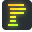

In [5]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 estimator = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

Almost all of the time spent by `fit` is required by the `create_train_X_y` method.

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:37:20  Samples:  63
 /_//_/// /_\ / //_// / //_'/ //     Duration: 3.475     CPU time: 0.375
/   _/                      v5.1.2

Cell [6]

3.474 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_33320\4842675.py:1
`- 3.473 ForecasterRecursive.fit  skforecast\recursive\_forecaster_recursive.py:956
      [13 frames hidden]  sklearn, joblib, subprocess, threading
         3.360 _ThreadHandle.join  <built-in>
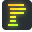

In [6]:
%%pyinstrument

forecaster = ForecasterRecursive(
                 estimator = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

When training a forecaster with a real machine learning estimator, the time spent by `create_train_X_y` is negligible compared to the time needed by the `fit` method of the estimator. Therefore, improving the speed of `create_train_X_y` will not have much impact.

## Profiling create_train_X_y

Understand how the `create_train_X_y` method is influenced by the length of the series and the number of lags. 

In [7]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterRecursive(
                     estimator = DummyRegressor(),
                     lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc - tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data = results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.000930,0.002984,0.007866,0.067912,0.099678
250750,0.004021,0.006663,0.026110,0.048842,0.085276
500500,0.009054,0.010208,0.124620,0.242955,0.276606
750250,0.014182,0.021288,0.159742,0.275449,0.634418
1000000,0.014742,0.035790,0.234586,0.377583,0.740515


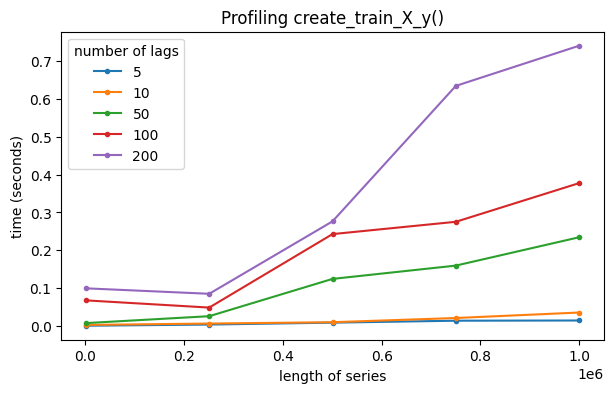

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');

## Profiling predict

In [9]:
forecaster = ForecasterRecursive(
                 estimator = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ The number of bins has been reduced from 10 to 1 due to duplicated edges caused by   │
│ repeated predicted values.                                                           │
│                                                                                      │
│ Category : skforecast.exceptions.IgnoredArgumentWarning                              │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\preproc │
│ essing\preprocessing.py:2432                                                         │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

AttributeError: 'DummyRegressor' object has no attribute 'coef_'

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:37:28  Samples:  2
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.003     CPU time: 0.000
/   _/                      v5.1.2

Cell [10]

0.002 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_33320\3639615597.py:1
`- 0.002 ForecasterRecursive.predict  skforecast\recursive\_forecaster_recursive.py:1629
      [12 frames hidden]  skforecast, pandas, warnings, re
         0.001 DataFrame._set_is_copy  pandas\core\generic.py:4401
         0.001 ord  <built-in>
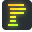

In [10]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

In [11]:
forecaster = ForecasterRecursive(
                 estimator = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:37:30  Samples:  806
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.201     CPU time: 6.406
/   _/                      v5.1.2

Cell [12]

1.200 <module>  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_33320\3639615597.py:1
|- 0.980 ForecasterRecursive.predict  skforecast\recursive\_forecaster_recursive.py:1629
|     [27 frames hidden]  skforecast, sklearn, <built-in>
|        0.442 TreePredictor.predict  sklearn\ensemble\_hist_gradient_boosting\predictor.py:49
|        `- 0.422 [self]  sklearn\ensemble\_hist_gradient_boosting\predictor.py
`- 0.220 [self]  C:\Users\jaesc2\AppData\Local\Temp\ipykernel_33320\3639615597.py
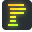

In [12]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the estimator.